In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of FeatureRelated.feature_data_holder failed: Traceback (most recent call last):
  File "/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/emil/miniconda3/envs/emocog/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/emil/miniconda3/envs/emocog/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../FeatureRelated/feature_data_holder.py", line 7, in <module>
    get_ipython().run_line_magic('matplot

In [72]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Vis import ClassificationVis, LabelVis
from Evals import *
from Data_Provider import *
from Util import ClassificationUtils as util
from Util import DataUtils as dutil


import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [73]:
#important configs
configs = dutil.load_configs()
print(configs) #is this what we want?

{'sliding': 10, 'wsize': 100, 's_sample': 0, 'e_sample': 30000, 's_sample_ev': 30000, 'e_sample_ev': 35000, 'cutoff': 0.2}


In [74]:
try:
    x,y,x_ev,y_ev = dutil.get_data_from_file(configs)
except:
    raise NameError('File does not exist')


(2839, 89)
(2839,)
(420, 89)
(420,)


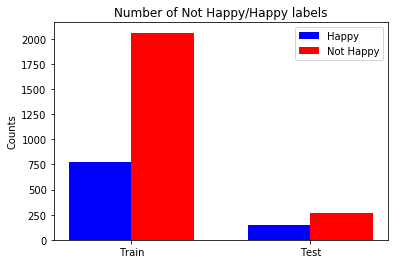

In [75]:
print(x.shape)
print(y.shape)
print(x_ev.shape)
print(y_ev.shape)

LabelVis.plot_happy_bars(y,y_ev)


In [76]:
# Run classifier with cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
results_rf = pd.DataFrame(columns=('Number Estimators','Max Depth','Max Features','AVG PR'))#,'AUC ROC'))
est = np.random.choice(np.arange(130)[5:],50)
max_d = np.random.choice(np.arange(60)[1:],50)
max_f = np.random.choice(np.arange(min(x.shape))[1:],50)

for idx,(c,d,f) in enumerate(zip(est,max_d,max_f)):
    classifier = RandomForestClassifier(n_estimators=c, max_depth=d, max_features=f,random_state=0)
    auc_pr = util.get_auc_score(classifier, cv, x, y, go_after_pr=True)
    #auc_roc =util.get_auc_score(classifier, cv, x, y, go_after_pr=False)
    results_rf.loc[idx] = [c,d,f,auc_pr]
    print('Number Estimators= %d, Max Depth = %d, Max Feat = %d, AUC PR %.3f' % (c,d,f,auc_pr))
    


Number Estimators= 44, Max Depth = 30, Max Feat = 49, AUC PR 0.963
Number Estimators= 58, Max Depth = 18, Max Feat = 48, AUC PR 0.962
Number Estimators= 38, Max Depth = 15, Max Feat = 54, AUC PR 0.958
Number Estimators= 25, Max Depth = 27, Max Feat = 5, AUC PR 0.954
Number Estimators= 28, Max Depth = 48, Max Feat = 22, AUC PR 0.959
Number Estimators= 41, Max Depth = 46, Max Feat = 10, AUC PR 0.962
Number Estimators= 30, Max Depth = 2, Max Feat = 73, AUC PR 0.546
Number Estimators= 129, Max Depth = 5, Max Feat = 37, AUC PR 0.863
Number Estimators= 117, Max Depth = 27, Max Feat = 57, AUC PR 0.965
Number Estimators= 71, Max Depth = 53, Max Feat = 48, AUC PR 0.964
Number Estimators= 121, Max Depth = 31, Max Feat = 81, AUC PR 0.960
Number Estimators= 40, Max Depth = 49, Max Feat = 78, AUC PR 0.961
Number Estimators= 104, Max Depth = 7, Max Feat = 32, AUC PR 0.933
Number Estimators= 5, Max Depth = 33, Max Feat = 55, AUC PR 0.852
Number Estimators= 63, Max Depth = 33, Max Feat = 56, AUC PR 0.

In [68]:
dutil.save_results(results_rf,configs,'_rf') # save results for later use

In [69]:
best_choice = util.get_best_hyperparas_results(results_rf, 'AVG PR') #what were the best hyperparas?
print(best_choice)
best_n,best_d,best_f =best_choice[:3]

Number Estimators    91.000000
Max Depth            27.000000
Max Features         10.000000
AVG PR                0.696759
Name: 1, dtype: float64


1.0 1.0 1.0
0.0 0.0 0.0


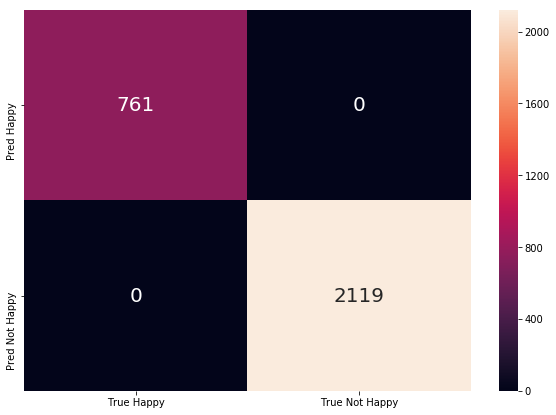

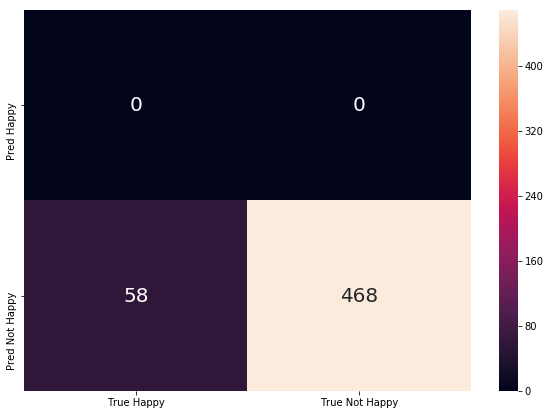

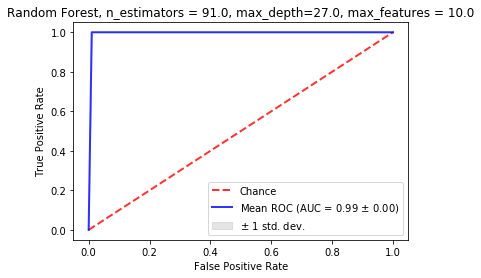

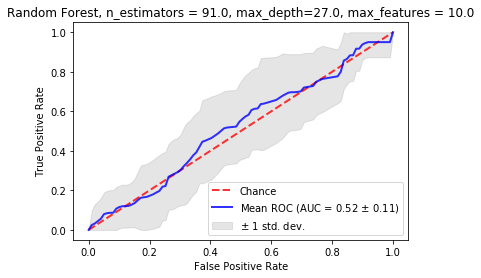

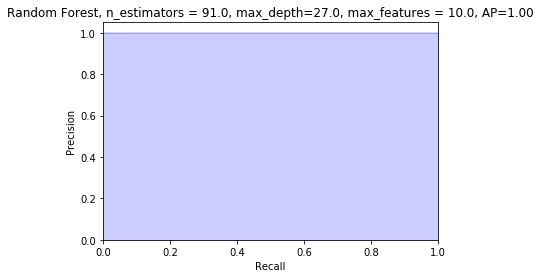

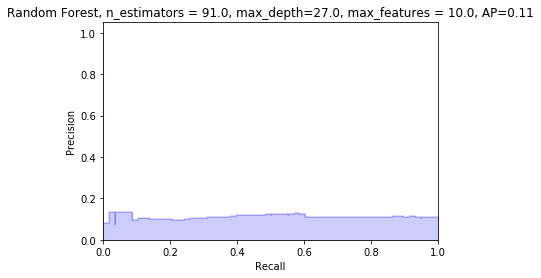

In [70]:
###using hyperpara found, evaluate and get pretty plots
#get f1 scores on whole training set

classifier = RandomForestClassifier(n_estimators=int(best_n), max_depth=int(best_d), max_features=int(best_f), random_state=0)
best_thr = util.get_optimal_threshold(classifier, cv, x, y, go_after_pr=True) # get threshold using cv
y_pred,y_pred_ev = util.fit_predict(classifier, best_thr, x, y, x_ev, y_ev) # using that threshold, get predictions and f1 score
f1_tr=get_f1(y_pred,y) # calculate f1 scores for prediction on train set
f1_ev=get_f1(y_pred_ev,y_ev)
prec_tr,recall_tr = get_precision_recall(y_pred,y)
prec_ev,recall_ev = get_precision_recall(y_pred_ev,y_ev)

print(prec_tr, recall_tr,f1_tr)
print(prec_ev, recall_ev,f1_ev)

ClassificationVis.conf_mat(y_pred,y)
ClassificationVis.conf_mat(y_pred_ev,y_ev)
plt.show()

ClassificationVis.plot_roc(x,y,classifier, 'Random Forest, n_estimators = {}, max_depth={}, max_features = {}'.format(best_n,best_d,best_f))
ClassificationVis.plot_roc(x_ev,y_ev,classifier, 'Random Forest, n_estimators = {}, max_depth={}, max_features = {}'.format(best_n,best_d,best_f))
ClassificationVis.plot_pr_curve(x,y,classifier,'Random Forest, n_estimators = {}, max_depth={}, max_features = {}'.format(best_n,best_d,best_f))
ClassificationVis.plot_pr_curve(x_ev,y_ev,classifier,'Random Forest, n_estimators = {}, max_depth={}, max_features = {}'.format(best_n,best_d,best_f))

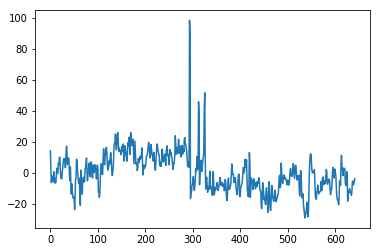

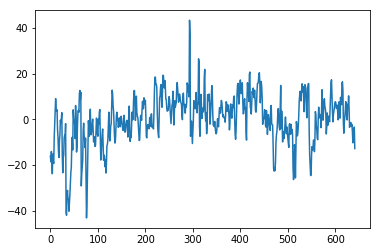

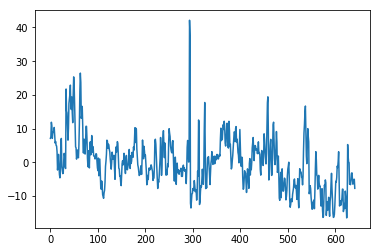

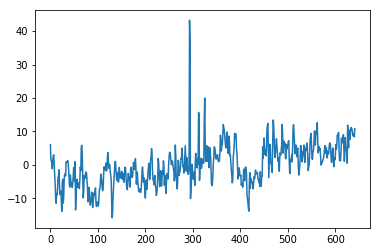

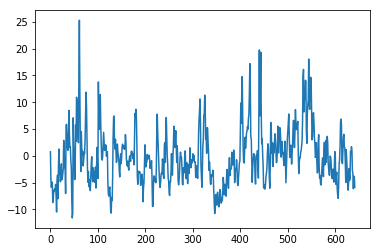

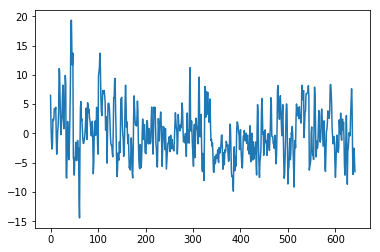

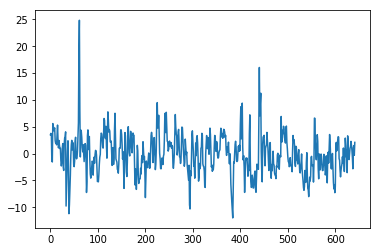

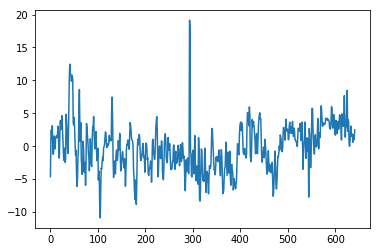

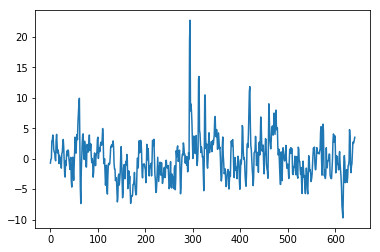

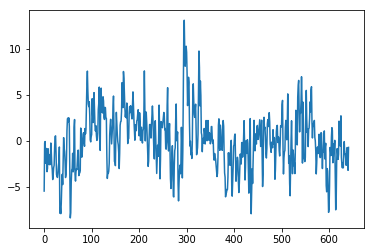

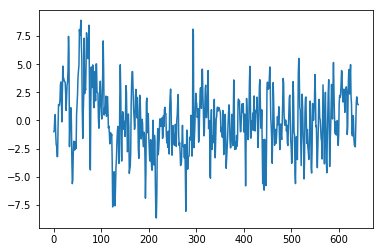

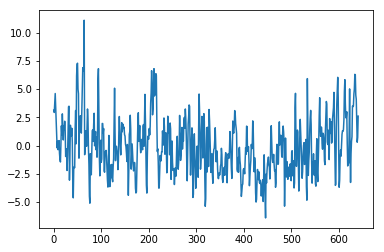

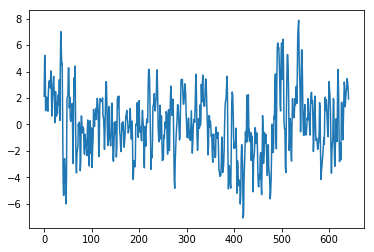

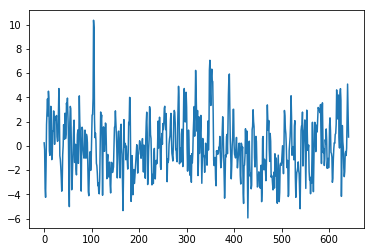

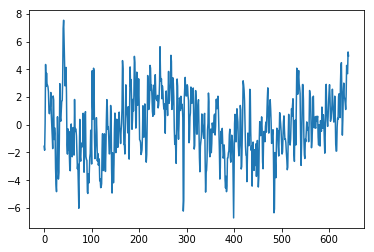

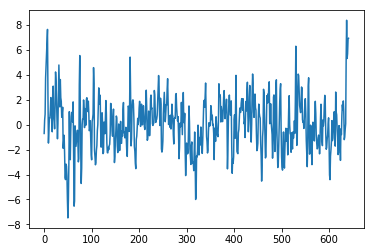

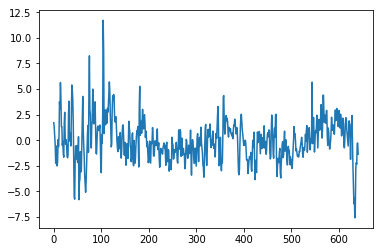

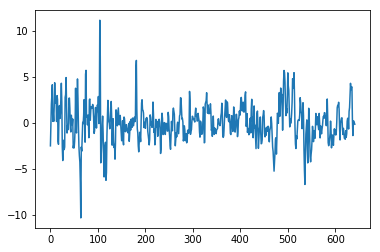

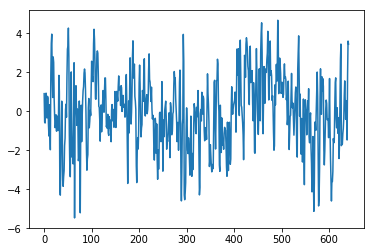

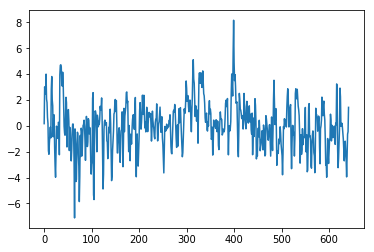

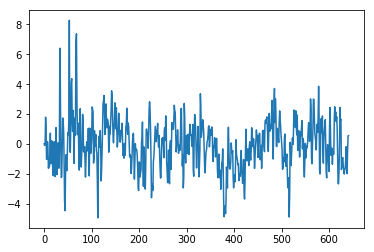

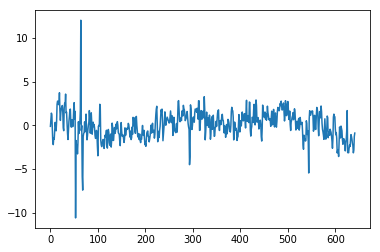

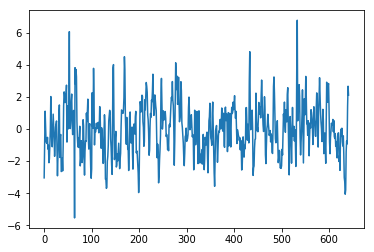

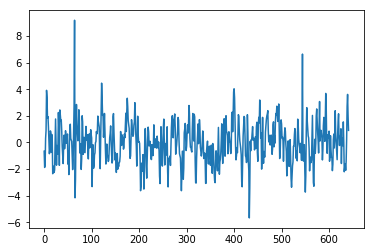

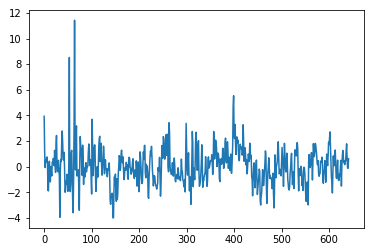

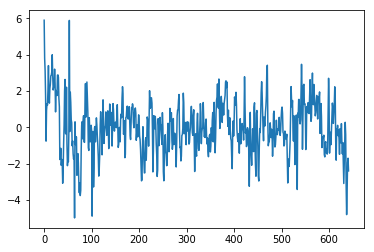

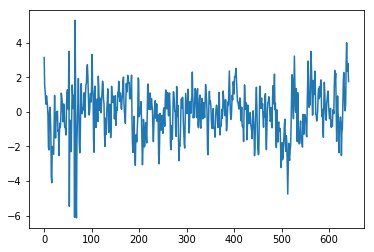

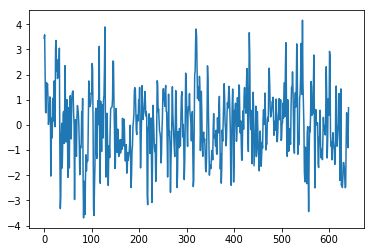

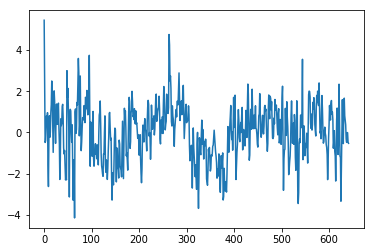

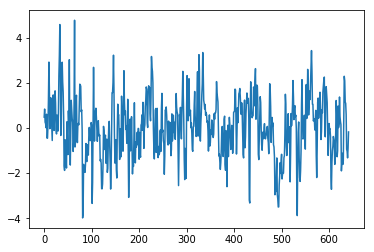

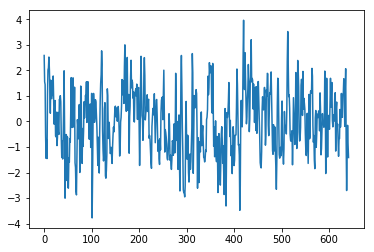

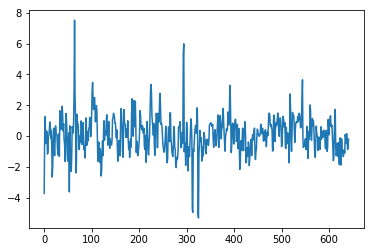

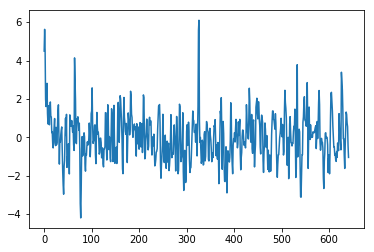

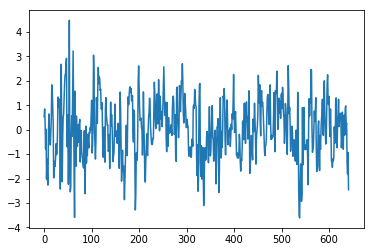

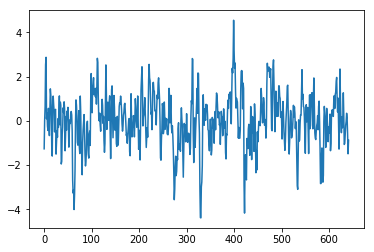

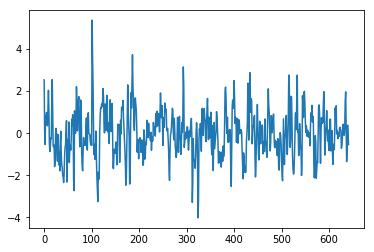

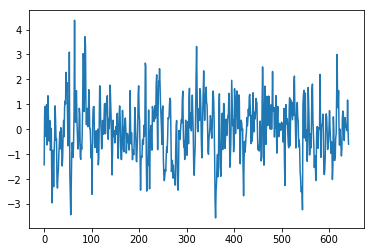

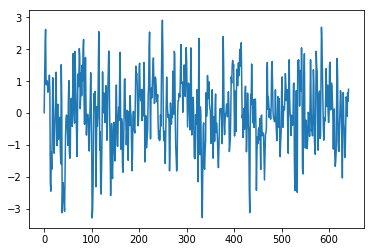

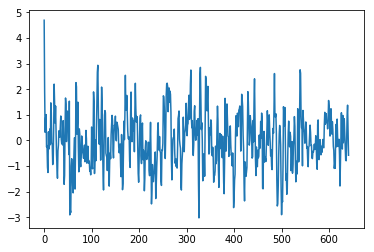

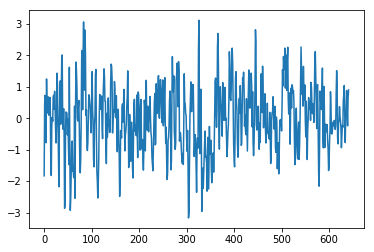

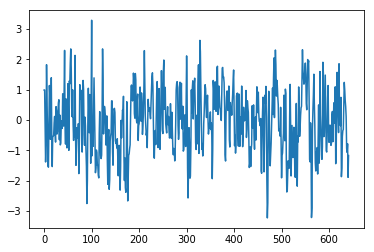

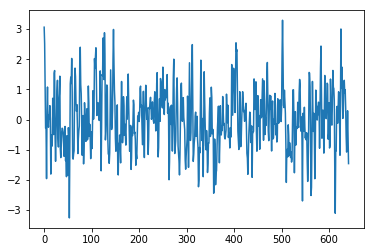

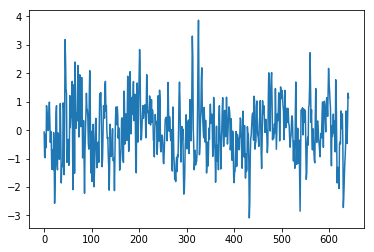

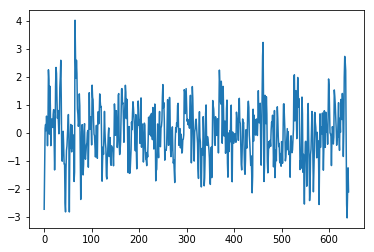

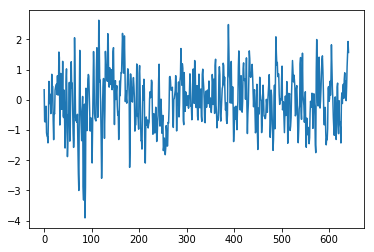

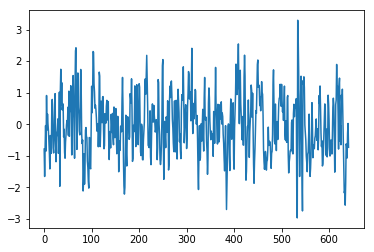

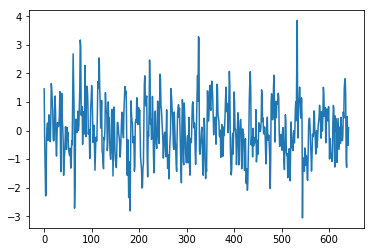

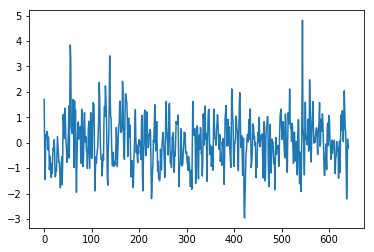

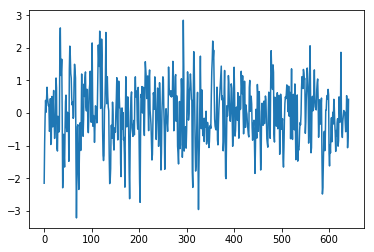

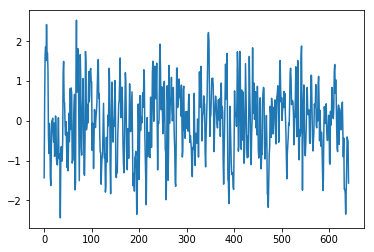

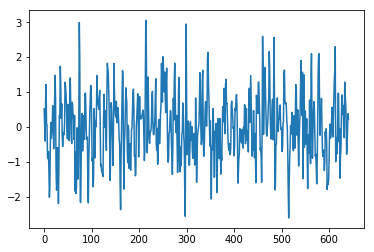

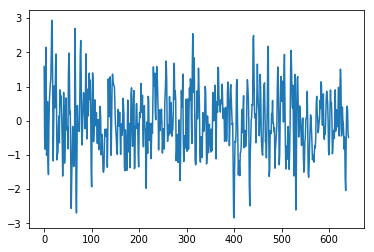

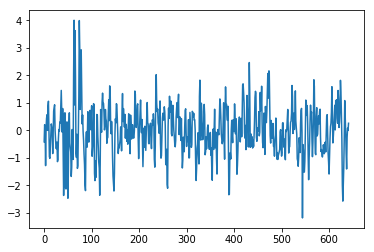

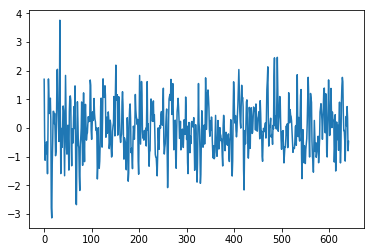

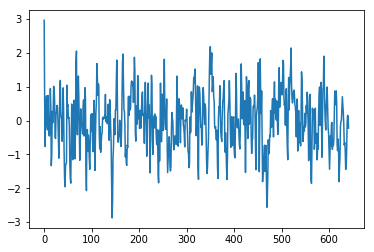

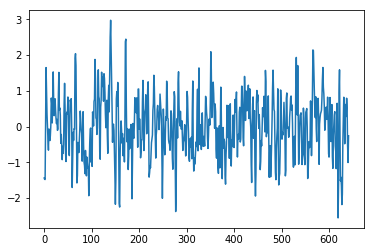

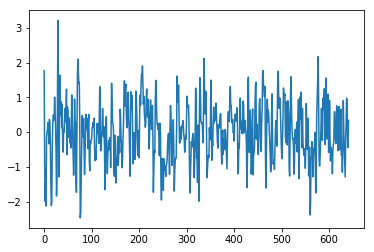

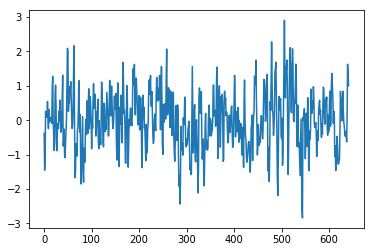

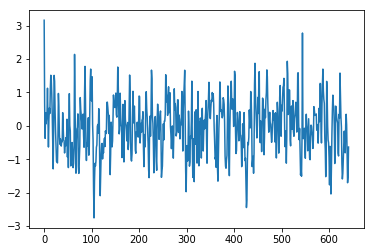

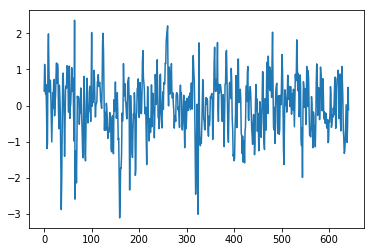

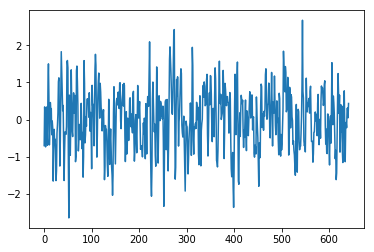

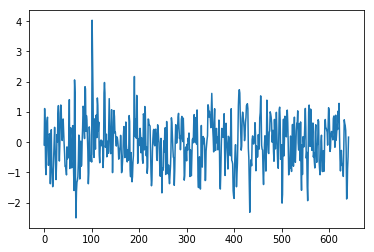

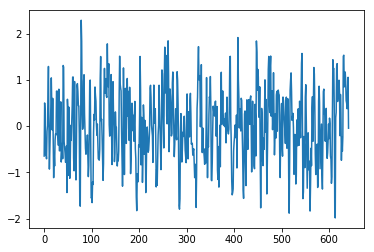

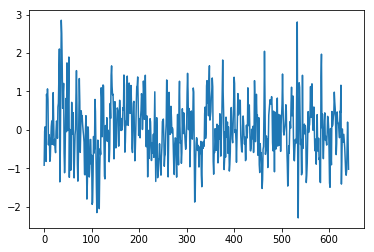

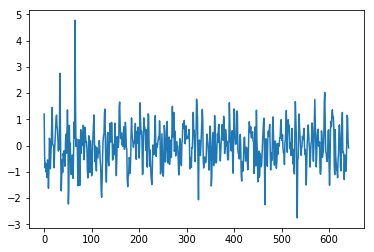

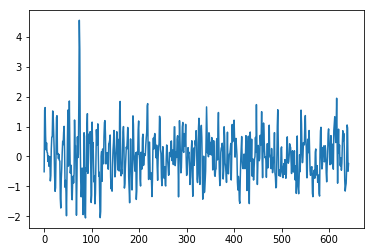

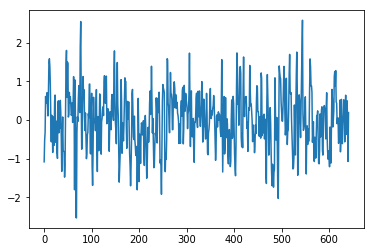

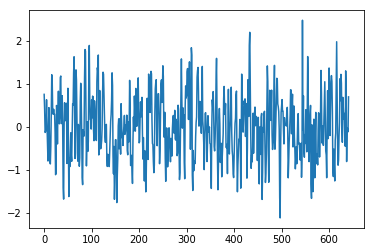

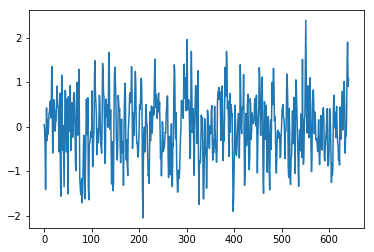

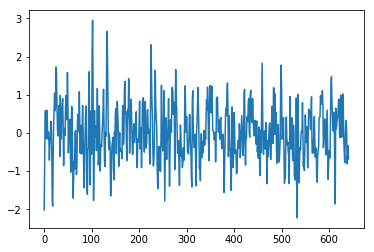

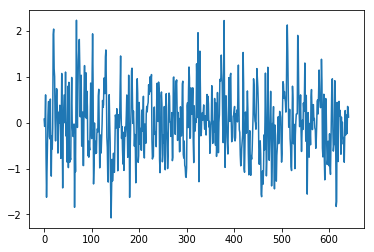

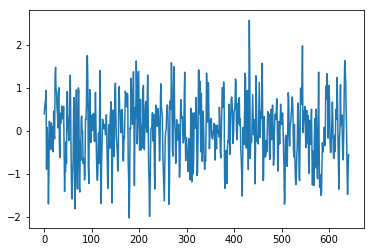

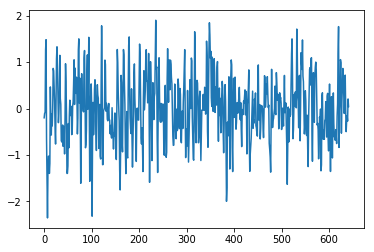

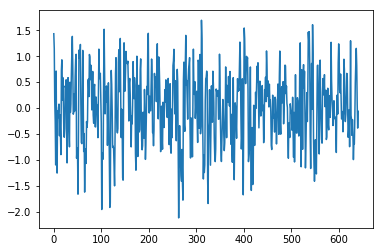

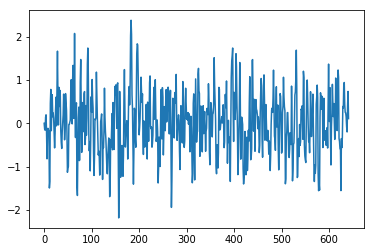

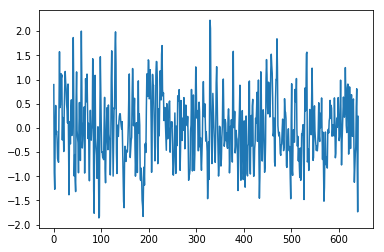

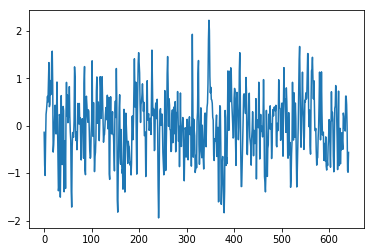

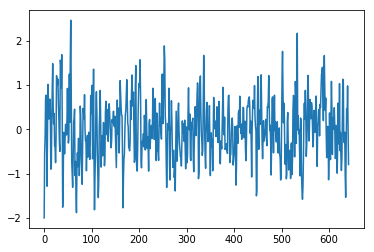

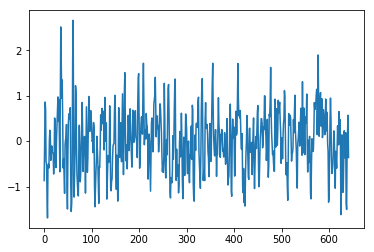

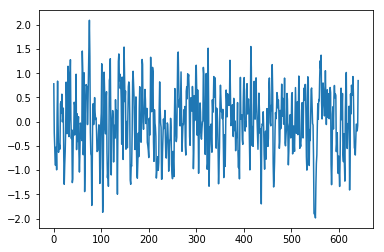

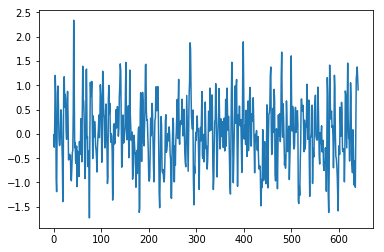

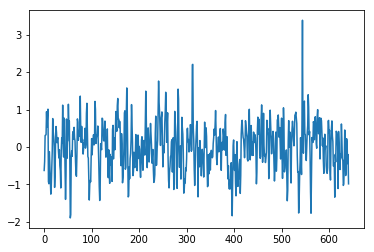

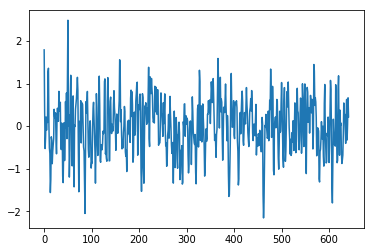

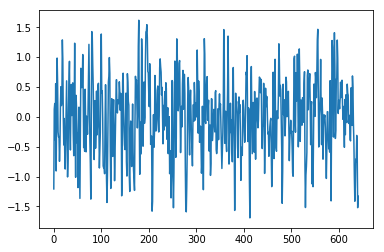

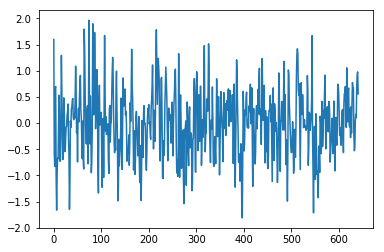

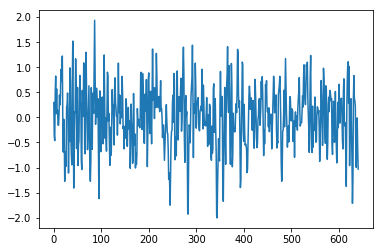

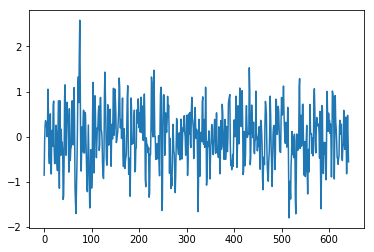

In [61]:
for i in range(x.shape[1]):
    plt.plot(x[:,i])
    plt.show()
